# Goal -  To build a machine learning model that is able to answer which customers are profitable, and decide who to approve.
How business works :
- Selected customers are given cards
- Customers make transactions depending upon their limits, credi_line
- Company earns commission on each transaction and as interest on leftover amount 
- If customer defaults, whole amount is lost 

         -Tasks performed in this file
             - Bi-variate Anslysis
             - Outlier detection
             - Feature Addition/removal
             - Model building
             - Hyper-parameter tuning
             - Model Evaluation
         -Analyst - Rageeni Sah
         -Date - 29th Sept, 2018

## Import libraries

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import Imputer, StandardScaler
from datetime import datetime
from scipy.stats import skew
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import  precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.svm import SVC

import warnings
warnings.filterwarnings(action = 'ignore')
%matplotlib inline
pd.set_option('display.max_colwidth', 100)

## Load train and test dataset

In [34]:
def load_dataset():
    train_df = pd.read_csv('puzzle_train_dataset.csv')
    test_df = pd.read_csv('puzzle_test_dataset.csv')
    return train_df, test_df
    
train_df, test_df = load_dataset()   
print('Train Datasize: {} and Test Datasize {}'.format(train_df.shape, test_df.shape))

Train Datasize: (64592, 29) and Test Datasize (35000, 28)


## Univariate Analysis

In [35]:
numerical_features = train_df.select_dtypes(include = [np.number]).columns
categorical_features = train_df.select_dtypes(include = [np.object]).columns

train_df = train_df[(train_df['default'] == True) | (train_df['default'] == False) ]
# target varibale binarization
train_df.default = train_df.default.map({True:1, False:0})

#Numerical and Date features handling
# This is imputer function for binary_factor
def num_imputer(train_df, test_df, feature):
    imp_num = Imputer( missing_values=np.nan, strategy='median')
    train_df[feature] = imp_num.fit_transform(train_df[[feature]])
    test_df[feature] = imp_num.transform(test_df[[feature]])
    
num_feture = ['score_3', 'score_4', 'score_5', 'score_6', 'risk_rate',
       'amount_borrowed', 'borrowed_in_months', 'credit_limit', 'income',
       'ok_since', 'n_bankruptcies', 'n_defaulted_loans', 'n_accounts',
       'n_issues']
for each in num_feture:
    num_imputer(train_df, test_df, each)
    
####### Categorical and Date features handling ###################
########## Gender ###################
def gender_tran(df):
    x = df['gender'].map({'m':1, 'f':0})
    return x
train_df.gender = gender_tran(train_df)
test_df.gender  = gender_tran(test_df)

# This is imputer function for binary_factor
def imputer(train_df, test_df, feature):
    imp_freq = Imputer( missing_values=np.nan, strategy='most_frequent')
    train_df[feature] = imp_freq.fit_transform(train_df[[feature]])
    test_df[feature] = imp_freq.transform(test_df[[feature]])
    
# call Imputer
imputer(train_df, test_df, 'gender')   

############# facebook_profile #################
def fp_tran(df):
    x = df['facebook_profile'].map({True:1, False:0})
    return x
train_df.facebook_profile = fp_tran(train_df)
test_df.facebook_profile  = fp_tran(test_df)

# call Imputer
imputer(train_df, test_df, 'facebook_profile')

############### sign #####################
# Imputer done
var = 'sign'
value = train_df[var].value_counts().index[0]
train_df[var].fillna(value, inplace = True, axis = 0)
test_df[var].fillna(value, inplace = True, axis = 0)


#### 'score_1', 'reason','score_2', 'state','zip','channel','job_name','real_state',last_payment, end_last_loan  ###
features_varLen = ['score_1', 'reason','score_2', 'state','zip','channel','job_name','real_state']

train_df.drop(features_varLen, axis = 1, inplace = True)
test_df.drop(features_varLen, axis = 1, inplace = True)
###############  last_payment, end_last_loan ###############
var = 'end_last_loan'
value = train_df[var].value_counts().index[0]
train_df[var].fillna(value, inplace = True, axis = 0)
test_df[var].fillna(value, inplace = True, axis = 0)

var = 'last_payment'
value = train_df[var].value_counts().index[0]
train_df[var].fillna(value, inplace = True, axis = 0)
test_df[var].fillna(value, inplace = True, axis = 0)

def cal_date(df):
    final_date = []
    date_format = "%Y-%m-%d"
    
    for d1, d2 in zip(df.last_payment, df.end_last_loan):
        delta = datetime.strptime(d2, date_format) - datetime.strptime(d1, date_format)
        final_date.append(delta.days)
    return final_date

train_df['date_diff_bt_loanEnd_lastPayment'] = cal_date(train_df)
test_df['date_diff_bt_loanEnd_lastPayment'] = cal_date(test_df)

# drop 'last_payment', 'end_last_loan', 'score_5' (~zero variance)
var = ['end_last_loan', 'last_payment', 'score_5']

train_df.drop(var, axis = 1, inplace = True)
test_df.drop(var, axis = 1, inplace = True)

In [36]:
# final dataset
train_df.head()

,ids,default,score_3,score_4,score_6,risk_rate,amount_borrowed,borrowed_in_months,credit_limit,income,sign,gender,facebook_profile,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,date_diff_bt_loanEnd_lastPayment
0,810e3277-619e-3154-7ba0-ebddfc5f7ea9,0,710.0,104.174961,123.015325,0.43,20024.31,60.0,62386.0,59869.05,virg,0.0,1.0,14.0,1.0,0.0,9.0,9.0,396
1,b4118fd5-77d5-4d80-3617-bacd7aaf1a88,0,330.0,97.880798,110.913484,0.23,10046.51,36.0,25338.0,46016.31,sagi,0.0,0.0,75.0,0.0,0.0,3.0,10.0,0
2,a75638f1-4662-4f4f-044a-d649b676d85d,0,360.0,97.908925,104.620791,0.30,21228.25,60.0,25338.0,48025.47,libr,1.0,1.0,32.0,0.0,0.0,5.0,10.0,181
3,285ce334-3602-42b3-51cb-eebfcba48a09,0,120.0,100.434557,120.134718,0.15,23032.33,36.0,25338.0,46011.12,libr,1.0,0.0,32.0,0.0,0.0,5.0,10.0,0
4,e643bf65-9288-92f2-df13-eed631fe237c,0,330.0,103.774638,104.320462,0.08,24026.29,36.0,32366.0,90026.17,libr,1.0,0.0,15.0,0.0,0.0,10.0,10.0,151


In [37]:
# dummy encoding on 'sign' and dropping 'sign'
train_df = pd.concat([train_df, pd.get_dummies(train_df.sign)], axis = 1)
train_df.drop('sign', axis = 1, inplace = True)

test_df = pd.concat([test_df, pd.get_dummies(test_df.sign)], axis = 1)
test_df.drop('sign', axis = 1, inplace = True)

print('Train set size:',train_df.shape)
print('Test set size :',test_df.shape)

Train set size: (59966, 30)
Test set size : (35000, 29)


## Baviate Analysis
        - Scatter plot
        - correlation coefficient check

In [38]:
features = ['default', 'score_3', 'score_4', 'score_6',
       'risk_rate', 'amount_borrowed', 'borrowed_in_months', 'credit_limit', 'income', 'ok_since', 'n_bankruptcies', 
            'n_defaulted_loans', 'n_accounts', 'n_issues', 'date_diff_bt_loanEnd_lastPayment']

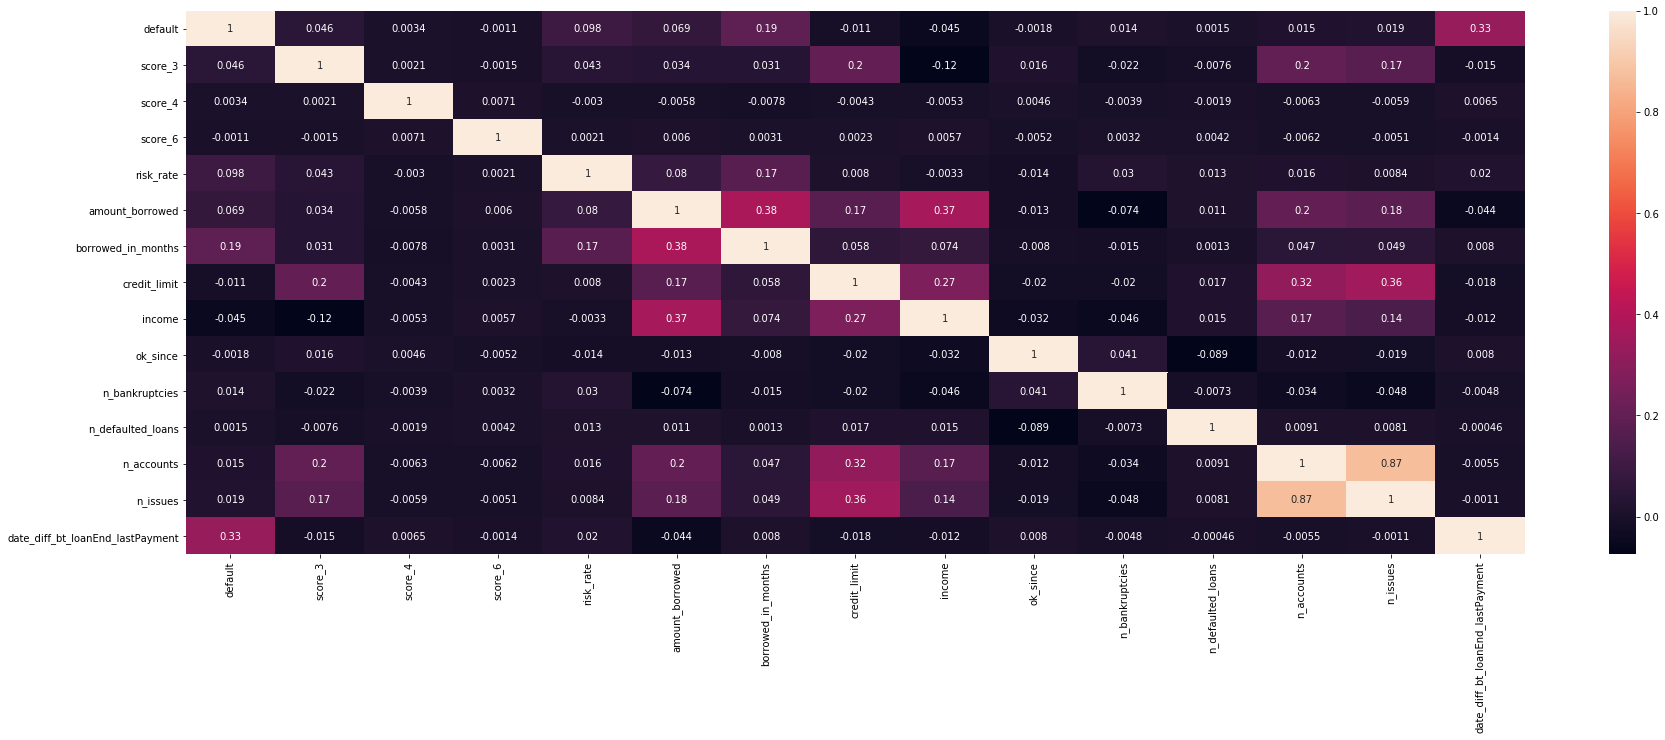

In [39]:
# pearson correlation coefficient
plt.figure(figsize=(30,10))
sns.heatmap(train_df[features].corr(), annot= True, robust=True, yticklabels=1)
# There is no - significant correlation among features except between 'n_accounts' and 'n_issues'.

    - 'default' has relatively higher correlation with 'borrowed_in_months', 'date_diff_bt_loanEnd_lastPayment', ''score_3',
        'risk_rate','amount_borrowed', 'income', 'n_issues'

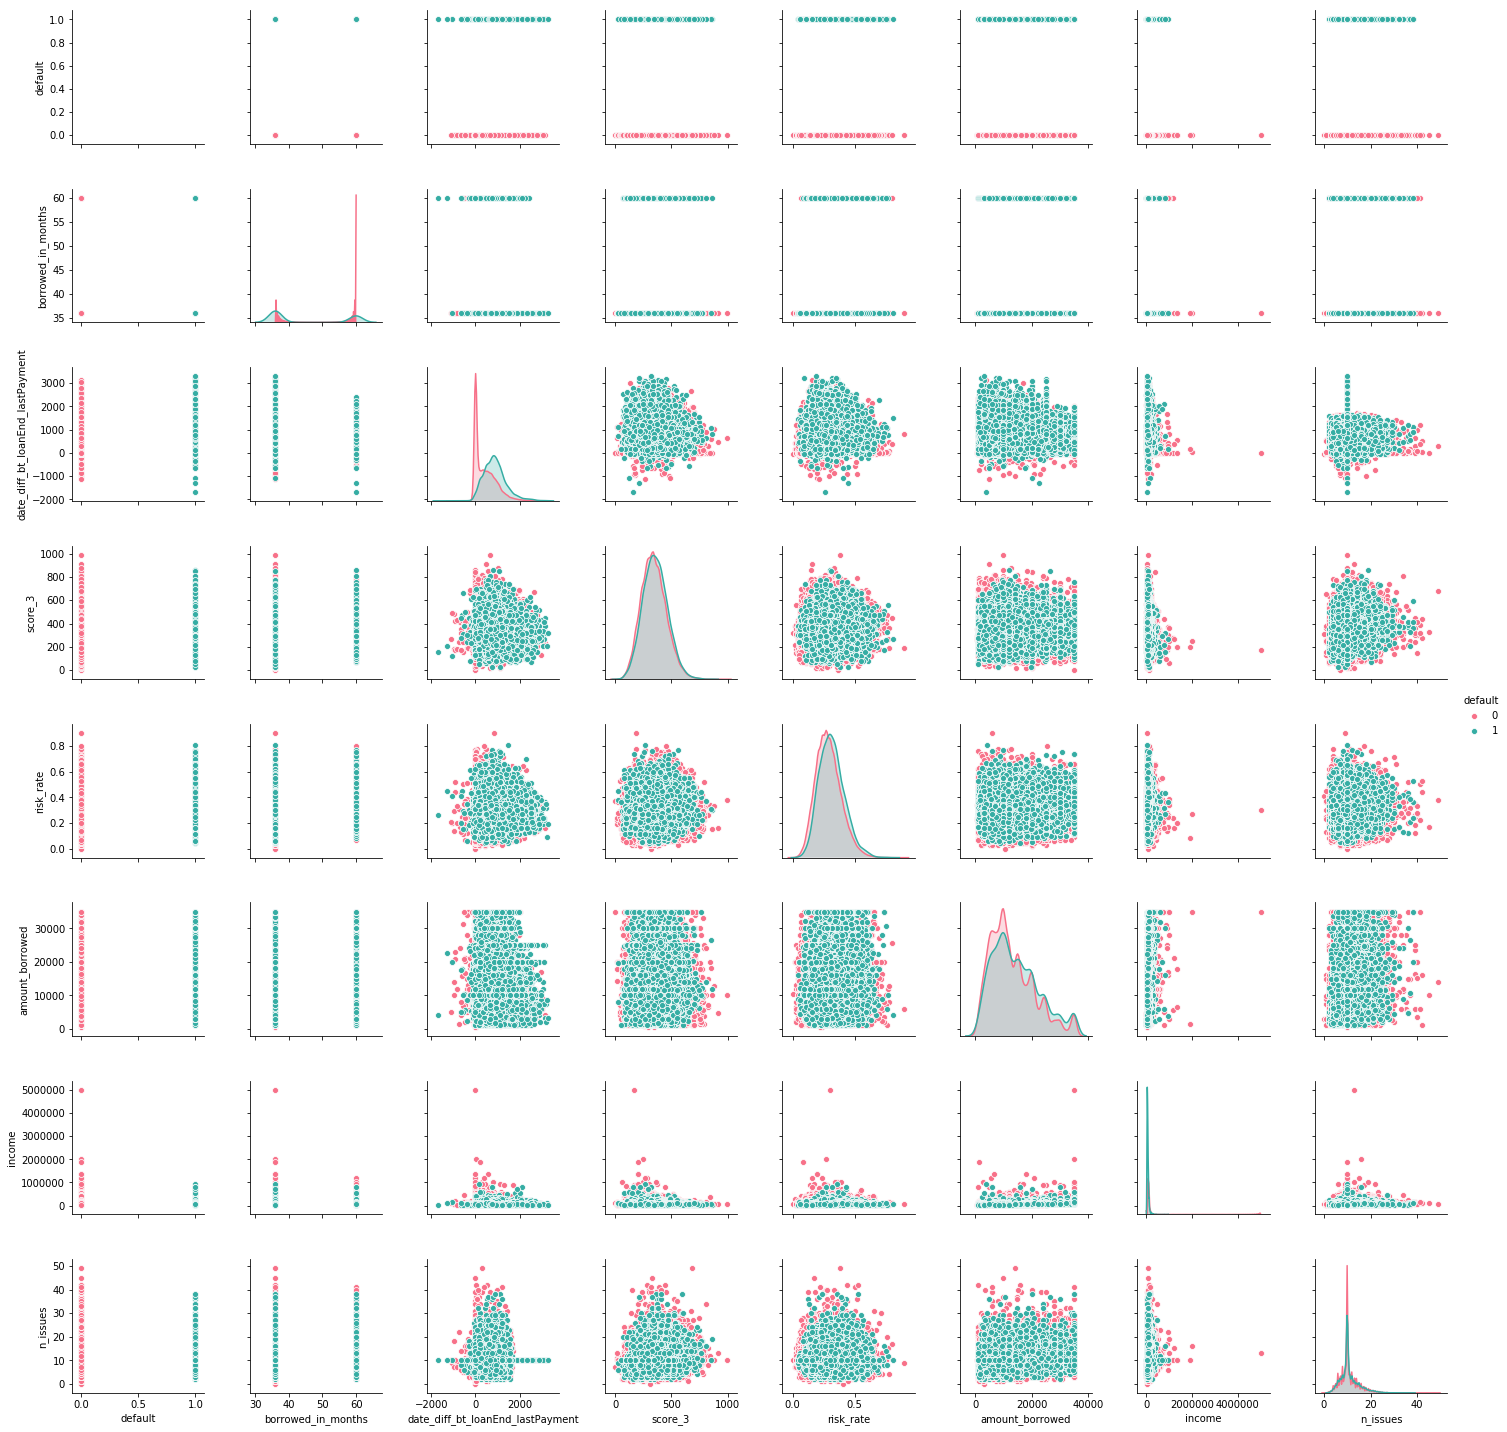

In [40]:
# pairplot
n_feature = ['default','borrowed_in_months', 'date_diff_bt_loanEnd_lastPayment', 'score_3',
        'risk_rate','amount_borrowed', 'income', 'n_issues']
sns.pairplot(train_df[n_feature], hue='default', palette="husl")

## Transformation
'borrowed_in_months', 'date_diff_bt_loanEnd_lastPayment', 'score_3',
        'risk_rate','amount_borrowed', 'income', 'n_issues'

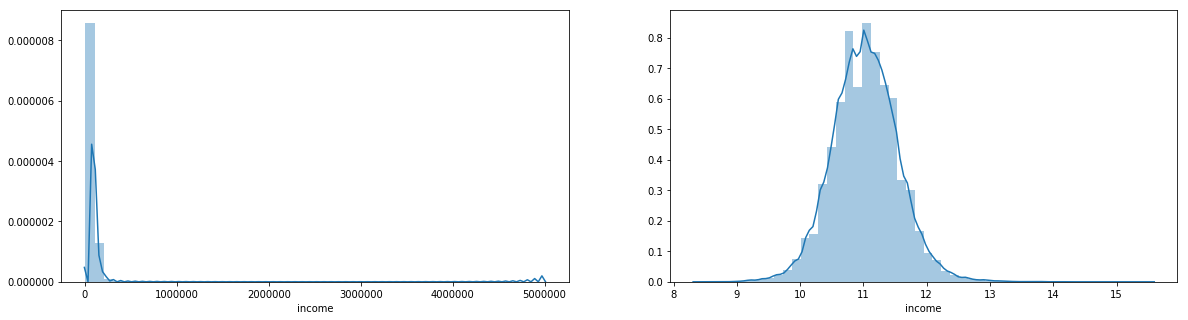

In [41]:
var = 'income'
fig, ax = plt.subplots(1, 2, figsize = (20,5))
sns.distplot(train_df[var], ax= ax[0])
sns.distplot(np.log1p(train_df[var]), ax= ax[1])

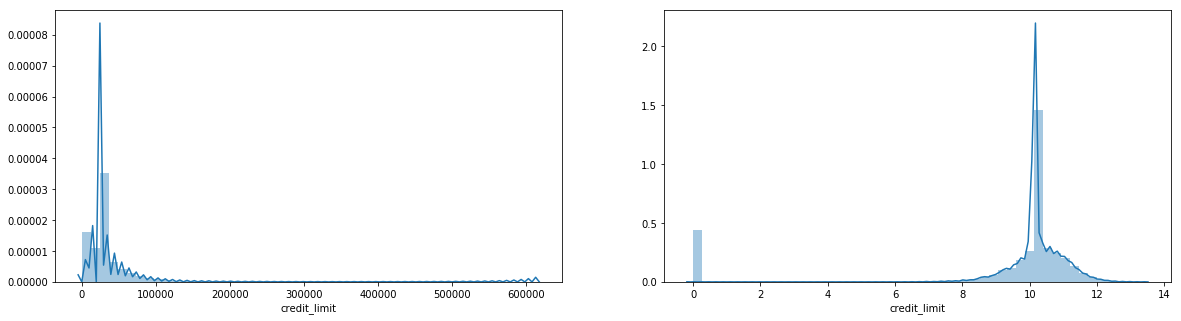

In [42]:
var = 'credit_limit'
fig, ax = plt.subplots(1, 2, figsize = (20,5))
sns.distplot(train_df[var], ax= ax[0])
sns.distplot(np.log1p(train_df[var]), ax= ax[1])

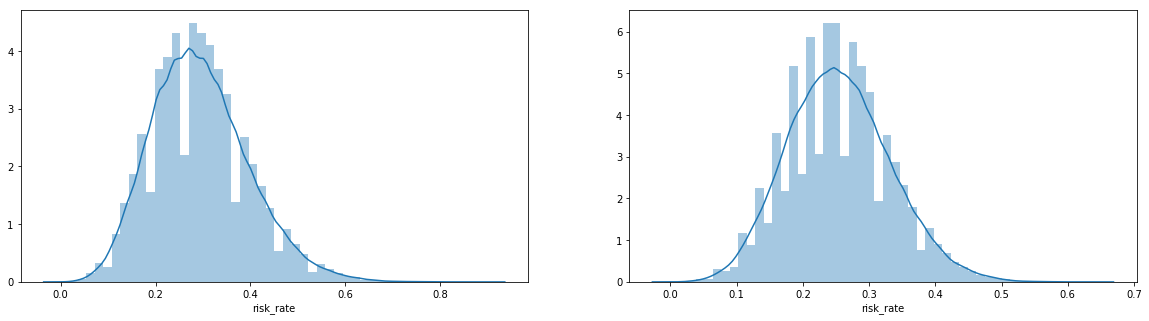

In [43]:
var = 'risk_rate'
fig, ax = plt.subplots(1, 2, figsize = (20,5))
sns.distplot(train_df[var], ax= ax[0])
sns.distplot(np.log1p(train_df[var]), ax= ax[1])

In [44]:
# varibale 'borrowed_in_months' has only two values hence, setting 36 = 1 and 60 == 1
train_df['borrowed_in_months'] = train_df['borrowed_in_months'].map(lambda x: 1 if x==60 else 0)
test_df['borrowed_in_months']   = test_df['borrowed_in_months'].map(lambda x: 1 if x==60 else 0)

# Map 'income' and 'credit_limit' in logarithm 
train_df['income'] = train_df['income'].map(lambda x: np.log1p(x))
test_df['income']   = test_df['income'].map(lambda x: np.log1p(x))
train_df['credit_limit'] = train_df['credit_limit'].map(lambda x: np.log1p(x))
test_df['credit_limit']   = test_df['credit_limit'].map(lambda x: np.log1p(x))

## Feature Selection

In [45]:
X = train_df.drop(['default','ids'], axis = 1)
y = train_df['default']

- RandomForestClassifier is used for model building for:
            - Feature Dimention is too high and would be more prone to overfitting
            - Random Forest is best selection for high varience 
            - SMOTE is used for over-sampling minority class

In [52]:
np.random.seed(42)
rf = RandomForestClassifier(random_state= True, bootstrap=True)
rf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=True, verbose=0,
            warm_start=False)

In [47]:
sig_df = pd.concat([ pd.DataFrame(X.columns, columns=['Features']), pd.DataFrame(rf.feature_importances_, 
                                                                                 columns=['Significance'])], axis = 1)
sig_df.sort_values(by = 'Significance', ascending = False)


,Features,Significance
15,date_diff_bt_loanEnd_lastPayment,0.192300
7,income,0.084867
4,amount_borrowed,0.078707
2,score_6,0.075478
1,score_4,0.072449
0,score_3,0.064986
3,risk_rate,0.062713
6,credit_limit,0.058797
13,n_accounts,0.045835
10,ok_since,0.043960


X = train_df[['score_3', 'score_4', 'score_6', 'risk_rate', 'amount_borrowed',
       'borrowed_in_months', 'credit_limit', 'income', 'gender',
       'facebook_profile','date_diff_bt_loanEnd_lastPayment']]

In [48]:
from sklearn.feature_selection import SelectKBest

selector = SelectKBest()
X = selector.fit_transform(X,y)
scaler = StandardScaler()
X = scaler.fit_transform(X,y)

# split into train and test set
trainX, testX, trainY, testY = train_test_split(X,y, test_size = 0.25, stratify = y)
print(trainX.shape)

(44974, 10)


## Hyper parameter tunning 
 - Hyper parameters for Random Forest are:
            - 'n_estimators'       -> number of trees 
            - 'max_depths'         -> maximun depth of each trees
            - 'max_features'       -> maximum number of features used for each tree
            - 'nsamples'           -> number of observations sampled randomly with replacement for each tree
            - 'min_split_features' -> minimum number of samples that must exits in each node for spliting of obervations/rows
            - 'min_samples_leaf'   -> mimumum number of samples in each node 
    - There are several more samples, however, model performance is highly influenced by tunning above parameters
   - Here: I have tunned only 'n_estimators' and 'max_depth' paramters while, retaining default values for other parameters

### Identifying feature score to start with

In [54]:
def RF_model(n_est, depth):
    rf = Pipeline(steps=[('sample', SMOTE(ratio = 'auto', k_neighbors= 5)),
                                    ('clf',RandomForestClassifier(n_estimators = n_est, max_depth=depth, random_state=42,
                                                                 bootstrap = True, max_features = 'sqrt',
                                                                 min_samples_leaf=100, min_samples_split=300)),])
    rf.fit(trainX, trainY)
    y_pred = rf.predict(testX)
    precision, recall, fscore, support = score(testY, y_pred, average = 'binary')
    print("Est--> {} Depth--> {}, Precision:{} --> Recall: {} --> Accuracy: {}".format(n_est, depth, round(precision,3), round(recall,3), round(((y_pred==testY).sum())/len(y_pred),3)))
# Identifying feature score to start with    
for n_est in [150, 500]:
    for depth in [10, 20, None]:
         RF_model(n_est, depth)
# Note- with depth = 30, 40 recall is very low

Est--> 150 Depth--> 10, Precision:0.347 --> Recall: 0.813 --> Accuracy: 0.728
Est--> 150 Depth--> 20, Precision:0.36 --> Recall: 0.789 --> Accuracy: 0.744
Est--> 150 Depth--> None, Precision:0.368 --> Recall: 0.785 --> Accuracy: 0.752
Est--> 500 Depth--> 10, Precision:0.348 --> Recall: 0.808 --> Accuracy: 0.73
Est--> 500 Depth--> 20, Precision:0.364 --> Recall: 0.789 --> Accuracy: 0.748
Est--> 500 Depth--> None, Precision:0.362 --> Recall: 0.788 --> Accuracy: 0.746


 Quick notes:
     - '1' positve class , '0' is negative class
     - Recall is very high for this model, while precision is low
     - Recall indicates fraction of true positive from actual positive
     - A low precision essentially means that the classifier returns a lot of false positives ( 0 is is returned as 1) 
     - Considering precisio - recall tradeoff, Low precision should be acceptable because, we cannot misclassify defaulters as non-defaulters, while it is OK to mis-classify none defaulters as defaulters

In [56]:
pm = Pipeline(steps=[('sample', SMOTE(ratio = 'auto', k_neighbors= 5)),
                                    ('clf',RandomForestClassifier(random_state=42,
                                                                 bootstrap = True, max_features = 'sqrt')),])
parameters = {'clf__n_estimators': [200,300,500],
              'clf__max_depth': [10,20],
             }

gs_clf = GridSearchCV(pm, parameters, cv = 2)
gs_clf = gs_clf.fit(trainX, trainY)
pd.DataFrame(gs_clf.cv_results_).sort_values('mean_test_score', ascending = False)[0:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__max_depth,param_clf__n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
4,14.623343,0.002609,3.340944,0.014329,20,300,"{'clf__max_depth': 20, 'clf__n_estimators': 300}",0.800062,0.805310,0.802686,0.002624,1,0.966781,0.961667,0.964224,0.002557
3,9.670877,0.022530,2.207341,0.005919,20,200,"{'clf__max_depth': 20, 'clf__n_estimators': 200}",0.799840,0.802686,0.801263,0.001423,2,0.967670,0.964379,0.966025,0.001645
5,23.932410,0.071945,5.538306,0.011893,20,500,"{'clf__max_depth': 20, 'clf__n_estimators': 500}",0.798906,0.802997,0.800952,0.002046,3,0.967048,0.968115,0.967581,0.000534
2,15.998368,0.040308,3.366223,0.020127,10,500,"{'clf__max_depth': 10, 'clf__n_estimators': 500}",0.734424,0.739361,0.736892,0.002468,4,0.758572,0.754881,0.756726,0.001846
0,6.599779,0.014500,1.377124,0.007238,10,200,"{'clf__max_depth': 10, 'clf__n_estimators': 200}",0.735047,0.738471,0.736759,0.001712,5,0.761596,0.754214,0.757905,0.003691


In [57]:
y_pred = gs_clf.best_estimator_.predict(testX)
precision, recall, fscore, support = score(testY, y_pred, average = 'binary')
print("Precision:{} --> Recall: {} --> Accuracy: {}".format(round(precision,3), round(recall,3), round(((y_pred==testY).sum())/len(y_pred),3)))

Precision:0.408 --> Recall: 0.632 --> Accuracy: 0.796


Quick notes:-
    - 'mean_test_score' gives accuracy of generalisation of the model. Currently, generalisation is 80%.
    -  As said, generalization of this model can be enhanced by tunning other hyper-parameters.

# Model perferomance can further be improved by tunning following parameters:
- min_split_features
- min_samples_leaf
- max_features
- nsamples
- Outliers handling
- Removing insignificant features
- Feature Engineering
- Using Advanced models

I have not used them as of now for, tunning each one of them would require ample time to try out several paramter combinations.

# prediction on test data

In [63]:
X_test = test_df.drop(['ids'], axis = 1)
X_test = selector.transform(X_test)
X_test = scaler.transform(X_test)
test_pred = gs_clf.best_estimator_.predict(X_test)
test_pred

array([0, 0, 0, ..., 0, 0, 0])

In [66]:
list(zip(test_df['ids'], test_pred))

[('e4366223-7aa2-0904-7a47-66479ae46b2a', 0),
 ('c6416108-c6d7-e6be-c4b5-923dd36c8ec4', 0),
 ('a90d3929-86ec-2414-89ba-543776b0e82b', 0),
 ('c5b96a7f-389a-28d0-242d-95db05e69da0', 1),
 ('1b461faa-926d-565d-b15d-0b452968ac81', 1),
 ('ca467139-2fe3-786b-b473-9bed607e71dc', 0),
 ('9d1cf9f2-0134-f173-b12a-df80ae8cfed0', 0),
 ('0895a45f-d761-8668-b7db-a1175f46af4c', 0),
 ('7dc64bfe-1d62-4a68-2287-3b272ad30208', 1),
 ('3d2705b3-d66b-b8f8-50d8-6327662334eb', 0),
 ('f588025e-3dbd-3a46-9b15-9194905cc550', 0),
 ('09d0767d-b84b-49c3-f8d7-8cb084354ebd', 0),
 ('80d5e958-6caa-6167-28f8-a720190593e1', 0),
 ('83a787ee-1c7d-9e59-02ac-6fba5f1851ff', 1),
 ('6a1725c9-a03e-720f-e694-451984ba8f78', 1),
 ('19317867-2d89-44ff-b42e-02f64e164384', 1),
 ('82029795-2959-b485-44b6-78fdae4d203d', 0),
 ('0b8be992-3435-7d5f-4521-eb7fabdf677b', 0),
 ('c1458197-ebc1-bc6b-3701-94e3026c9934', 0),
 ('6731dc45-0f4d-01eb-c2c9-2dd5e1e36f26', 0),
 ('38062c00-3ce8-95db-043c-ae07cde673c5', 0),
 ('ac2af657-976a-3e68-91b8-c89c603